# **Importación de paquetes**

In [2]:
#Importación de paquetes
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from scipy.stats.distributions import uniform
from Machine_Learning_Tools.plots import *
from Machine_Learning_Tools.models import *
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# **Análsis del dataset**

In [3]:
df = pd.read_csv('datasets/insurance.csv')
# Imprimimos los primeros 5 elementos del dataset
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Revisamos la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


El dataset no contiene datos nulos, tiene 6 variables; 2 de tipo float, 2 de tipo int y 3 de tipo object, además  de tener  1338 renglones. Las variables del dataset son:

- **age**: Edad del beneficiario primario.

- **sex**: Género del contratista del seguro(female y male).

- **bmi**: índice de masa corporal

- **children**: Número de hijos cubiertos por el seguro medico /  Número de dependientes.

- **smoker**: ''yes'' si el beneficiario primario fuma, ''no'' en caso contrario.

- **region**: Área de residencia de los beneficiarios en los Estado Unidos(northeast, southeast, southwest, northwest).

- **charges**: Costo del seguro médico.

In [9]:
# Descripción de las variables númericas
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# **Análisis descriptivo**

In [11]:
# Dividimos las variables en númericas y categóricas
numeric_features = ['age','bmi','charges']

categorical_features = ['sex','smoker','region','children']

In [21]:
for i in range(df.shape[0]):
    
    if df['children'].iloc[i]>=4:
        df['children'].iloc[i] = '4+'

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Se utilizará la variable **children** como categórica, en donde si la variable toma un valor mayor o igual a 4, entonces todos estos representaran una categoria llamada ''4+''.

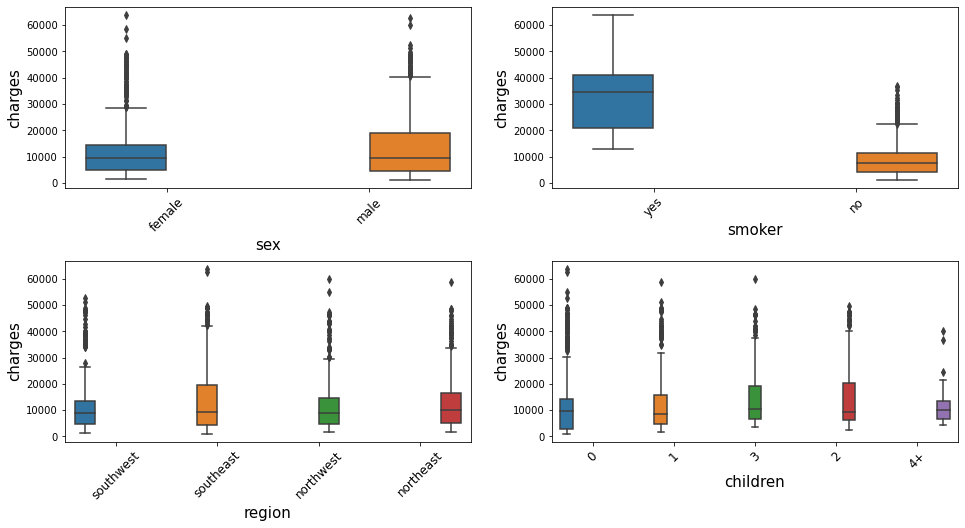

In [22]:
# Boxplot de las variable charges para cada una de las categorias de las variables, sex, smoker , region  y children
boxplot1(df,'charges',categorical_features,figsize=(16,8),label_size=15,xticks_size=12)

Del gráfico anterior, podemos deducir lo siguiente:

- La densidad de la variable charges tiene una moda, un mínimo y un máximo parecidos en ambas categorías de la variable sex,  aunque el valor del percentil  75 es mayor para la  categoría male, pero en general no se ve una diferencia clara en las densidades

- Hay una marcada diferencia en la densidad de los cargos dependiendo si la persona fuma o no.

- No hay un cambio tan significativo de los cargos para las diferentes regiones, las densidades son muy parecidas.

- Se percibe un cambio en las densidades de los cargos para las diferentes categorías de hijos, sobre todo la densidad en donde el seguro médico cubre a 5 hijos o más.

- Las variables **smoker**  y **children** son las que más nos podrían ayudar a predecir el monto de cargos del seguro médico.

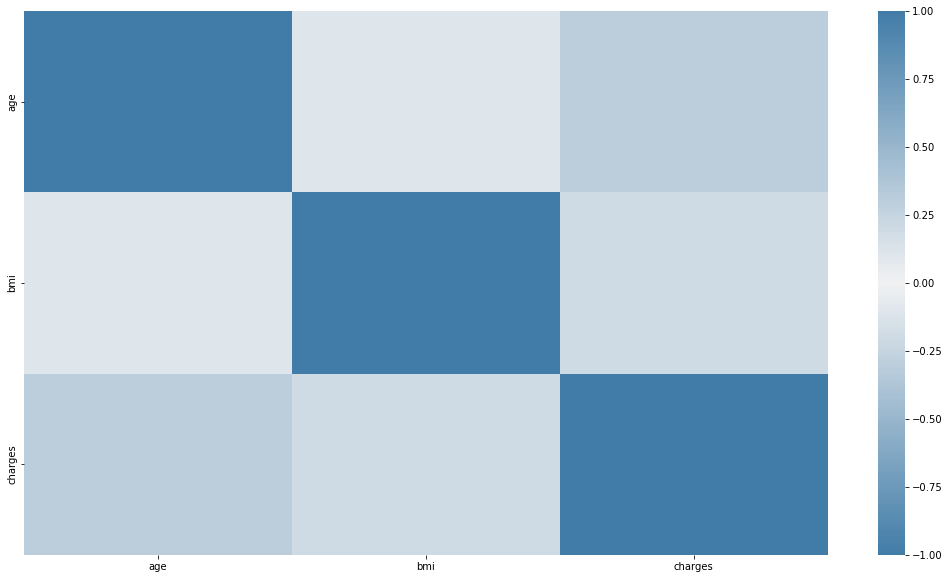

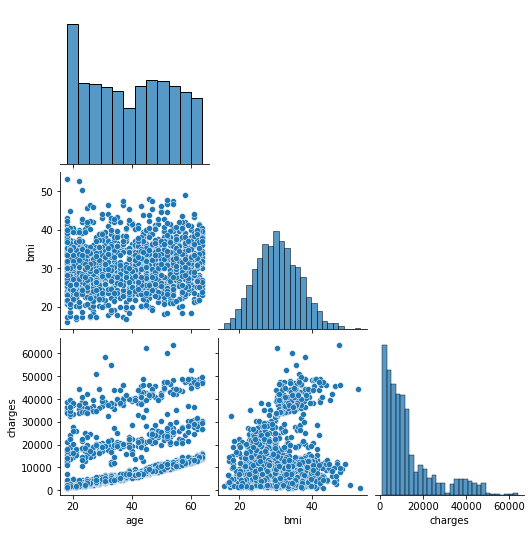

In [23]:
# Correlograma de las variables numericas
correlogram(df,numeric_features,figsize=(18,10))

#Paiplot de las variables numericas
pairplot(df,numeric_features)

- Hay algo de correlación de los cargos y la edad.

- Hay algo de correlación de los cargos y el bmi.

- No hay correlacion entre las variables **bmi** y **age**.

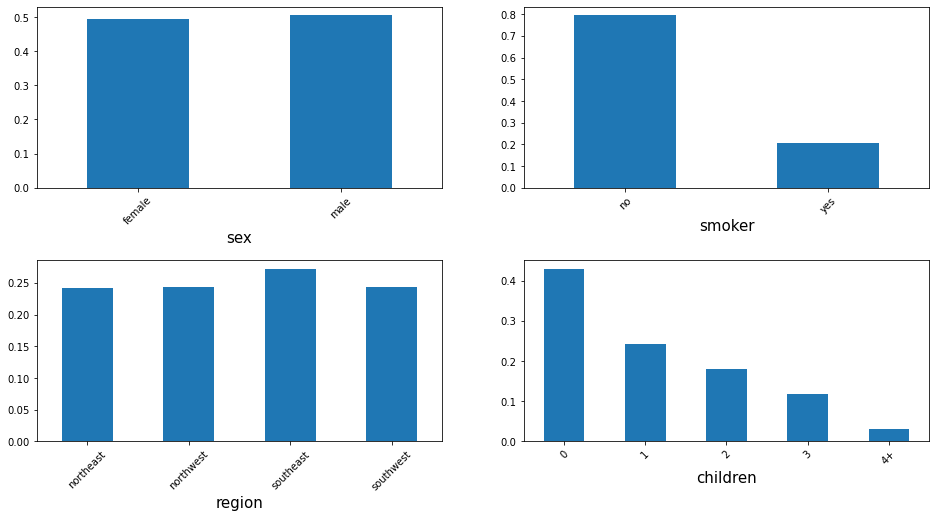

In [24]:
# barplot de las variables categóricas
barplot(df,categorical_features,figsize=(16,8))

El dataset está muy bien balanceado en las variables **region** y **sex**, en la variable **smoker** la población se concentra mayormente en los no fumadores, mientras que la variable **children** tiene una disminución.

# **Preprocesamiento de datos y definición de los modelos**

In [15]:
#Creamos una variable de los cargos dividida entre 10,000
df['charges10K'] = df.charges/10000
df['log_charges10K'] = np.log(df.charges10K)

In [16]:
#Definimos las variables predictora y las variables respuesta
features = df.columns[(df.columns!='charges') & (df.columns!='charges10K')]
target = ['log_charges10K'] 

In [17]:
# escalador y onehotencoder para las variables categóricas
scaler = MinMaxScaler()

encoder = OneHotEncoder(drop='first')

features_transformer = ColumnTransformer([
    ('numeric',scaler,numeric_features[:-1]),
    ('categorical',encoder,categorical_features)
])



# Modelo para la eleccion de variables

model_sel = DecisionTreeRegressor()


feature_selector = SelectFromModel(estimator=model_sel)

#Modelos a entrenar

#Regresión lineal
lr = LinearRegression()
# Suport Vector Machine e hiperparámetros
svm = SVR()
svm_params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[1,2,3,4],'coef0':uniform(),'tol':uniform(),
         'epsilon':uniform()}
# Random Forest e hiperparámetros

rfm = RandomForestRegressor()

rfm_params = {'n_estimators':[100,200,300,400,500],'criterion':["squared_error", "absolute_error", "poisson"]}

# **Entrenamiento**

## Linear Regression

In [18]:
#creamos un objeto de la clase supervised learning

lr_model = Supervised_Model(df,features,target,lr,'linear_regression')

#agregamos la transformación
lr_model.add_column_transformer(features_transformer)
#agregammos el selector de variables
lr_model.add_feature_selector(feature_selector)

metric = mean_squared_error
seed  = 100

cv_folds = 10
lr_model.cross_val_score(metric,cv_folds,seed)
lr_model.cv_score.mean(axis=0)

train    0.215687
test     0.217771
dtype: float64

## Suport Vector Machine

In [19]:
svm_model = Supervised_Model(df,features,target,svm,'SVM')
#agregamos la transformación
svm_model.add_column_transformer(features_transformer)
#agregammos el selector de variables
svm_model.add_feature_selector(feature_selector)

scoring = 'neg_mean_absolute_error'
iters = 50
svm_model.cv_hyperparameter_tuning(svm_params,iters,scoring)

In [21]:
-svm_model.best_score

0.21751070245300577

In [22]:
svm_model.best_params

{'coef0': 0.09223450661390586,
 'degree': 4,
 'epsilon': 0.08332454954434099,
 'kernel': 'rbf',
 'tol': 0.3413970441188059}

## Random Forest

In [23]:
rf_model = Supervised_Model(df,features,target,rfm,'Random Forest')
#agregamos la transformación
rf_model.add_column_transformer(features_transformer)
#agregammos el selector de variables
rf_model.add_feature_selector(feature_selector)

scoring = 'neg_mean_absolute_error'
iters = 10
rf_model.cv_hyperparameter_tuning(rfm_params,iters,scoring)

In [24]:
-rf_model.best_score

0.2601837067934373

In [25]:
rf_model.best_params

{'n_estimators': 300, 'criterion': 'absolute_error'}